#0a) Librerias a utilizar en este proyecto

In [ ]:
library(tidyverse)
library(janitor)
library(ggcorrplot)
library(maps)
library(treemapify)
library(ggrepel)
library(scales)
library(readr)

#1)  Cronolograma de las características del empleo provincial

Este codigo permite ver cómo se relacionan las variables: HHI, prop_mujeres, empleo_total, n_sectores, brecha_genero entre ellas.

Toma en cuenta la relacion entre estas variables por provincia (por eso creamos la tabla provincia_data al final de codigo) y lo condensa en un cronolograma.
Por ejemplo,

* Las provincias más concentradas (o sea, pocos sectores dominan) tienden a tener menos empleo. Esto puede verse en el -0,58 entre HHI y empleo total.

*	En provincias más concentradas, hay menos mujeres empleadas, aunque la relación es moderada.

* 	Donde hay más sectores, suele haber más empleo.

IMPORTANTE: El correlograma no muestra relaciones causales. Solo como estan relacionadas estas variables.
Para el cronolograma usamos ggcorrplot

In [ ]:


establecimientos <- establecimientos %>%
  mutate(empleo = as.numeric(empleo),
         proporcion_mujeres = as.numeric(proporcion_mujeres))

# 1. Proporción promedio de mujeres por provincia
prop_mujeres_prov <- establecimientos %>%
  group_by(provincia_id) %>%
  summarise(prop_mujeres = mean(proporcion_mujeres, na.rm = TRUE))

# 2. Empleo total por provincia (ahora con Empleo en mayúscula)
empleo_prov <- datos_total %>%
  group_by(provincia_id) %>%
  summarise(empleo_total = sum(empleo, na.rm = TRUE))

# 3. Número de sectores distintos (clae2) por provincia
n_sectores_prov <- datos_total %>%
  group_by(provincia_id) %>%
  summarise(n_sectores = n_distinct(clae2))

# 5. Calculamos HHI por provincia
hhi_provincia <- datos_total %>%
  group_by(provincia_id, clae2) %>%
  summarise(empleo = sum(empleo, na.rm = TRUE)) %>%
  group_by(provincia_id) %>%
  mutate(p = empleo / sum(empleo)) %>%
  summarise(HHI = sum(p^2))

# 7. Unimos todo y calculamos brecha salarial
provincia_data <- empleo_prov %>%
  left_join(n_sectores_prov, by = "provincia_id") %>%
  left_join(prop_mujeres_prov, by = "provincia_id") %>%
  left_join(hhi_provincia, by = "provincia_id") %>%
  left_join(ubicacion %>% select(provincia_id, provincia) %>% distinct(),
            by = "provincia_id") %>%
  mutate(brecha_genero = prop_mujeres - 0.5) %>%
  select(provincia, HHI, prop_mujeres, empleo_total,
         n_sectores, brecha_genero)
  print(provincia_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `empleo = as.numeric(empleo)`.
Caused by warning:
! NAs introduced by coercion”
`summarise()` has grouped output by 'provincia_id'. You can override using the
`.groups` argument.


# A tibble: 24 × 6
   provincia       HHI prop_mujeres empleo_total n_sectores brecha_genero
   <chr>         <dbl>        <dbl>        <dbl>      <int>         <dbl>
 1 CABA         0.0336        0.372      3137197         87        -0.128
 2 Buenos Aires 0.0409        0.369      4115444         87        -0.131
 3 Catamarca    0.0569        0.326        63784         77        -0.174
 4 Cordoba      0.0455        0.347      1050882         85        -0.153
 5 Corrientes   0.0647        0.264       159982         84        -0.236
 6 Chaco        0.0624        0.266       170500         83        -0.234
 7 Chubut       0.0531        0.400       196317         82        -0.100
 8 Entre Rios   0.0698        0.319       278325         80        -0.181
 9 Formosa      0.0816        0.293        51482         75        -0.207
10 Jujuy        0.0671        0.328       122316         81        -0.172
# ℹ 14 more rows


In [ ]:
library(ggcorrplot)

# 1. Creamos matriz de correlación
matriz_cor <- provincia_data %>%
  select(-provincia) %>%  # excluimos columna de texto
  cor(use = "complete.obs")  # ya no hay NAs, pero por seguridad

# 2. Visualizamos correlograma
ggcorrplot(matriz_cor,
           type = "lower",
           lab = TRUE,
           lab_size = 3,
           colors = c("blue", "white", "red"),
           title = "Relación entre variables estructurales por provincia",
           ggtheme = theme_minimal())

#2) Mapa de la brecha de genero en establecimiento productivos por provincia en el año 2022


🟩 En verde: se observa una mayor equidad entre trabajadores varones y mujeres, reflejando una participación más equilibrada en los distintos sectores productivos.

🟥 En rojo: se evidencian sectores con baja equidad de género, donde la participación de mujeres es significativamente menor, destacando brechas en la inserción laboral femenina.

In [ ]:

# 1. Mapa base de Argentina
mapa_prov <- map_data("world", region = "Argentina")

# 2. Proporción de mujeres por provincia (solo 2022)
prop_2022 <- establecimientos %>%
  filter(anio == 2022) %>%
  group_by(provincia_id) %>%
  summarise(prop_mujeres = mean(proporcion_mujeres, na.rm = TRUE), .groups = "drop") %>%
  left_join(ubicacion %>% select(provincia_id, provincia) %>% distinct(), by = "provincia_id")

# 3. Coordenadas promedio por provincia
coord_provincias <- establecimientos %>%
  group_by(provincia_id) %>%
  summarise(lat = mean(lat, na.rm = TRUE),
            lon = mean(lon, na.rm = TRUE), .groups = "drop") %>%
  left_join(ubicacion %>% select(provincia_id, provincia) %>% distinct(), by = "provincia_id")

# 4. Unimos datos para el mapa
puntos_mapa <- prop_2022 %>%
  left_join(coord_provincias, by = c("provincia_id", "provincia"))


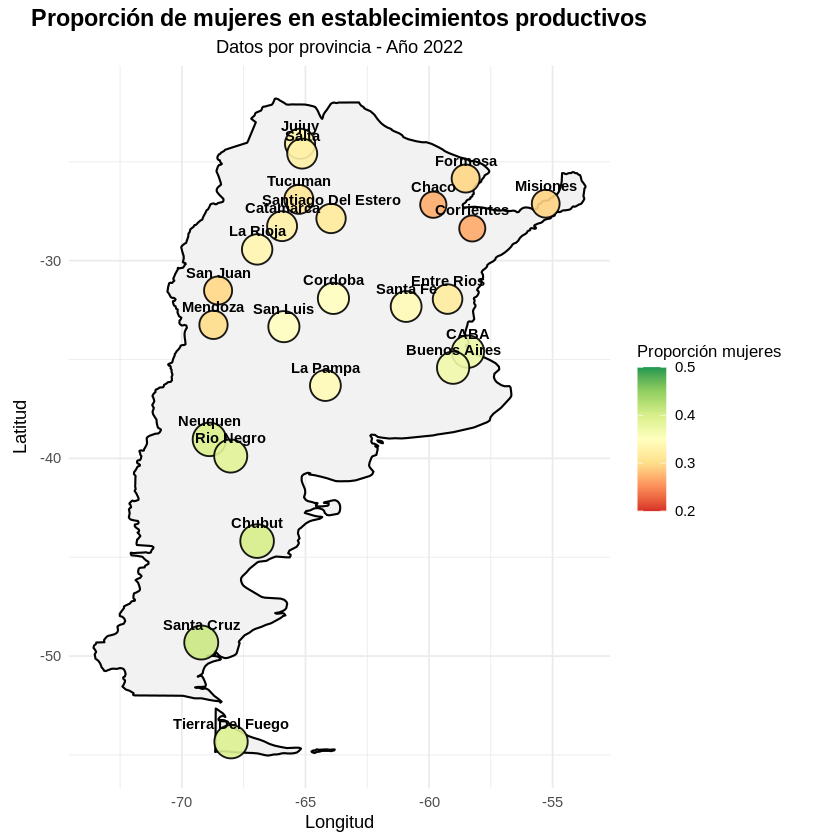

In [ ]:
# 5. Graficamos:

ggplot() +
  geom_polygon(data = mapa_prov, aes(x = long, y = lat, group = group),
               fill = "gray95", color = "black", linewidth = 0.6) +
  geom_point(data = puntos_mapa,
             aes(x = lon, y = lat, fill = prop_mujeres, size = prop_mujeres),
             shape = 21, color = "black", stroke = 0.8, alpha = 0.9) +
  geom_text(data = puntos_mapa,
            aes(x = lon, y = lat, label = provincia),
            size = 3.1, vjust = -1.3, fontface = "bold", color = "black") +
  scale_fill_gradientn(
    colors = c("#d73027", "#fc8d59", "#fee08b", "#ffffbf", "#d9ef8b", "#91cf60", "#1a9850"),
    name = "Proporción mujeres",
    limits = c(0.2, 0.5)
  ) +
  scale_size_continuous(range = c(4, 10), limits = c(0.2, 0.5)) +
  guides(size = "none") +
  coord_fixed(ratio = 0.8) +
  theme_minimal() +
  labs(
    title = "Proporción de mujeres en establecimientos productivos",
    subtitle = "Datos por provincia - Año 2022",
    x = "Longitud", y = "Latitud"
  ) +
  theme(
    legend.position = "right",
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    plot.subtitle = element_text(size = 11, hjust = 0.5),
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 9)
  )

#3  Mapa de establecimientos productivos por provincia (2022)

In [ ]:

# 1. Cargamos el mapa base de Argentina
mapa_prov <- map_data("world", region = "Argentina")

# 2. Agrupamos por provincia (total establecimientos)
conteo_est <- establecimientos %>%
  group_by(provincia_id) %>%
  summarise(n_est = n(), .groups = "drop") %>%
  left_join(ubicacion %>% distinct(provincia_id, provincia), by = "provincia_id")

# 3. COrdenamos las coordenadas promedio por provincia
coord_provincias <- establecimientos %>%
  group_by(provincia_id) %>%
  summarise(lat = mean(lat, na.rm = TRUE),
            lon = mean(lon, na.rm = TRUE), .groups = "drop") %>%
  left_join(ubicacion %>% distinct(provincia_id, provincia), by = "provincia_id")

# 4. Unimos todo
datos_mapa <- conteo_est %>%
  left_join(coord_provincias, by = c("provincia_id", "provincia"))


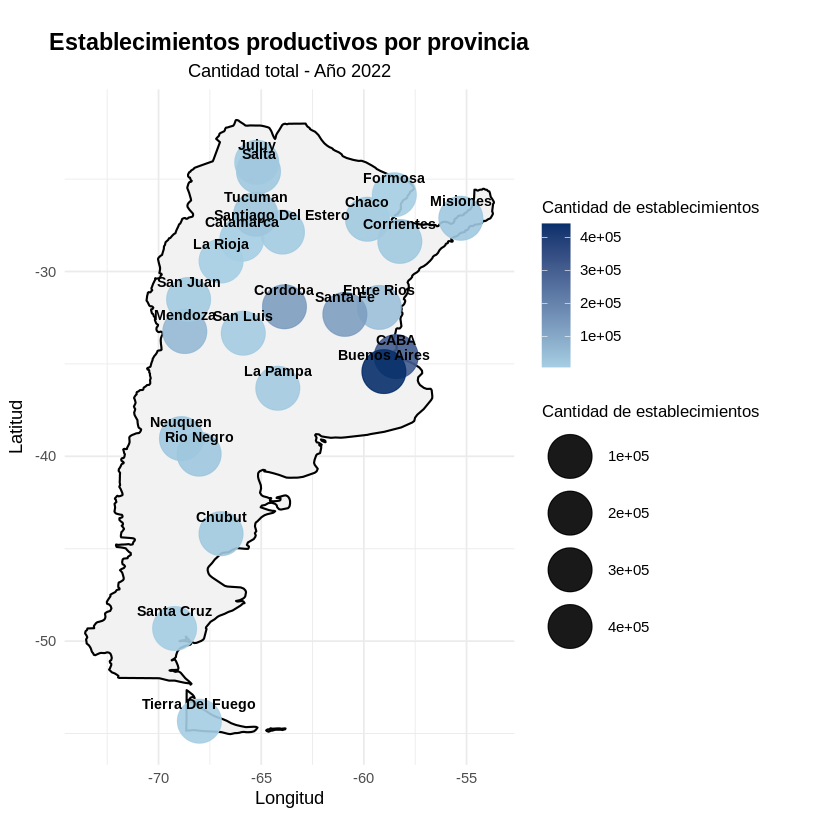

In [ ]:
# 5. Graficamos:

ggplot() +
  geom_polygon(data = mapa_prov, aes(x = long, y = lat, group = group),
               fill = "gray95", color = "black", linewidth = 0.6) +
  geom_point(data = datos_mapa,
             aes(x = lon, y = lat, color = n_est, size = n_est),
             alpha = 0.9) +
  geom_text(data = coord_provincias,
            aes(x = lon, y = lat, label = provincia),
            size = 3, vjust = -1.2, fontface = "bold") +
  scale_color_gradient(low = "#a6cee3", high = "#08306b", name = "Cantidad de establecimientos") +
  scale_size(range = c(12, 12), name = "Cantidad de establecimientos") +
  coord_fixed(ratio = 0.9) +
  theme_minimal() +
  labs(
    title = "Establecimientos productivos por provincia",
    subtitle = "Cantidad total - Año 2022",
    x = "Longitud", y = "Latitud"
  ) + theme(
    legend.position = "right",
    plot.title = element_text(face = "bold", size = 14, hjust = 0.5),
    plot.subtitle = element_text(size = 11, hjust = 0.5),
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 9))

#4 Treemap de la distribución regional de los establecimientos productivos

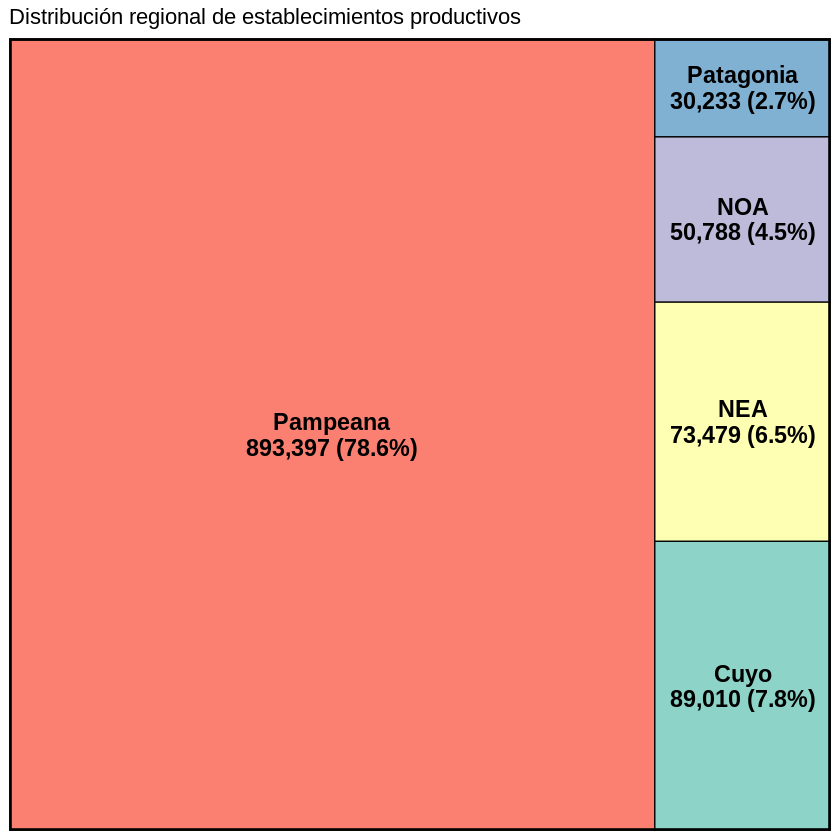

In [ ]:

# Diccionario de regiones con nombres que matchean a 'ubicacion/establecimientos'
regiones <- tibble(
  provincia = c("Salta", "Jujuy", "Tucumán", "Santiago del Estero", "Catamarca", "La Rioja",
                "Chaco", "Corrientes", "Formosa", "Misiones",
                "Mendoza", "San Juan", "San Luis",
                "Buenos Aires", "CABA", "Córdoba", "Santa Fe", "Entre Ríos", "La Pampa",
                "Neuquén", "Río Negro", "Chubut", "Santa Cruz", "Tierra del Fuego"),
  region = c(rep("NOA", 6),
             rep("NEA", 4),
             rep("Cuyo", 3),
             rep("Pampeana", 6),
             rep("Patagonia", 5))
)


establecimientos_region <- establecimientos %>%
  left_join(regiones, by = "provincia") %>%
  filter(!is.na(region)) %>%
  group_by(region) %>%
  summarise(
    total = n(),
    .groups = "drop"
  )

# Total nacional y etiquetas
total_nacional <- sum(establecimientos_region$total)

establecimientos_region <- establecimientos_region %>%
  mutate(
    porcentaje = total / total_nacional * 100,
    etiqueta   = paste0(region, "\n",
                        comma(total), " (", round(porcentaje, 1), "%)")
  )

ggplot(establecimientos_region,
       aes(area = total, fill = region, label = etiqueta)) +
  geom_treemap(color = "black", size = 1) +
  geom_treemap_text(
    colour   = "black",
    place    = "center",
    reflow   = TRUE,
    size     = 14,
    fontface = "bold"
  ) +
  scale_fill_brewer(palette = "Set3", guide = "none") +
  labs(title = "Distribución regional de establecimientos productivos") +
  theme_minimal() +
  theme(
    panel.border     = element_rect(color = "black", fill = NA, size = 1.5),
    panel.background = element_rect(fill = "white")
  )

#5) Empleo total por provincia y año

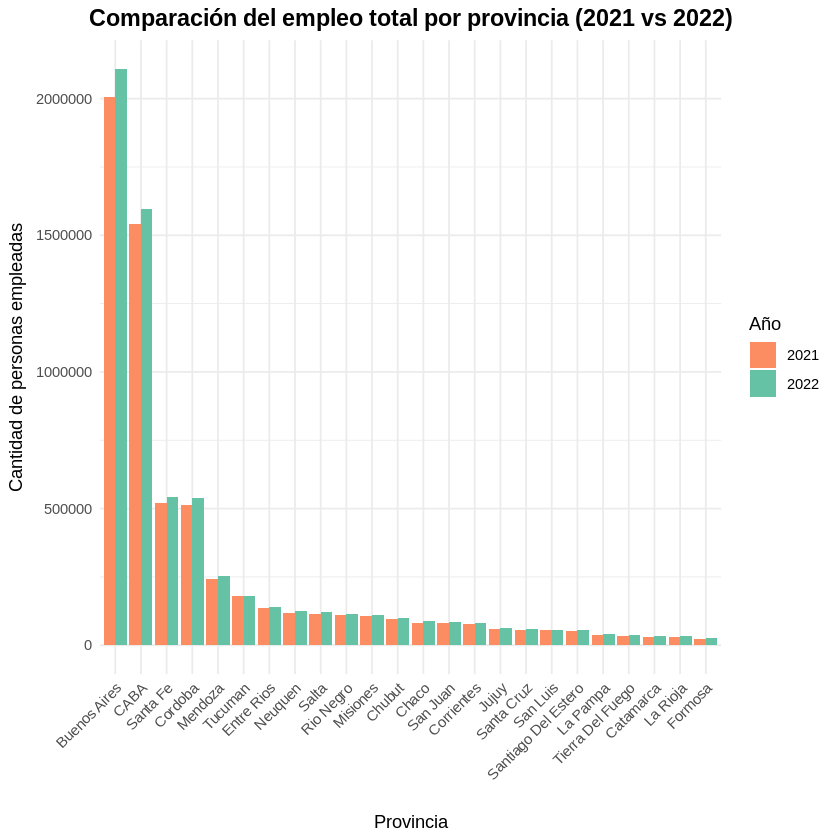

In [ ]:

# 1. Agrupación
empleo_prov_anio <- datos_total %>%
  group_by(anio, provincia) %>%
  summarise(empleo_total = sum(empleo, na.rm = TRUE), .groups = "drop")

# 2. Ordenar provincias según empleo total en 2022
orden_provincias <- empleo_prov_anio %>%
  filter(anio == 2022) %>%
  arrange(desc(empleo_total)) %>%
  pull(provincia)

empleo_prov_anio$provincia <- factor(empleo_prov_anio$provincia, levels = orden_provincias)

# 3. Gráfico mejorado
ggplot(empleo_prov_anio, aes(x = provincia, y = empleo_total, fill = as.factor(anio))) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_fill_manual(values = c("2021" = "#fc8d62", "2022" = "#66c2a5"), name = "Año") +
  labs(
    title = "Comparación del empleo total por provincia (2021 vs 2022)",
    x = "Provincia",
    y = "Cantidad de personas empleadas"
  ) +
  theme_minimal(base_size = 11) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5)
  )


#6) Composición de género del empleo nacional: 2022 vs 2021

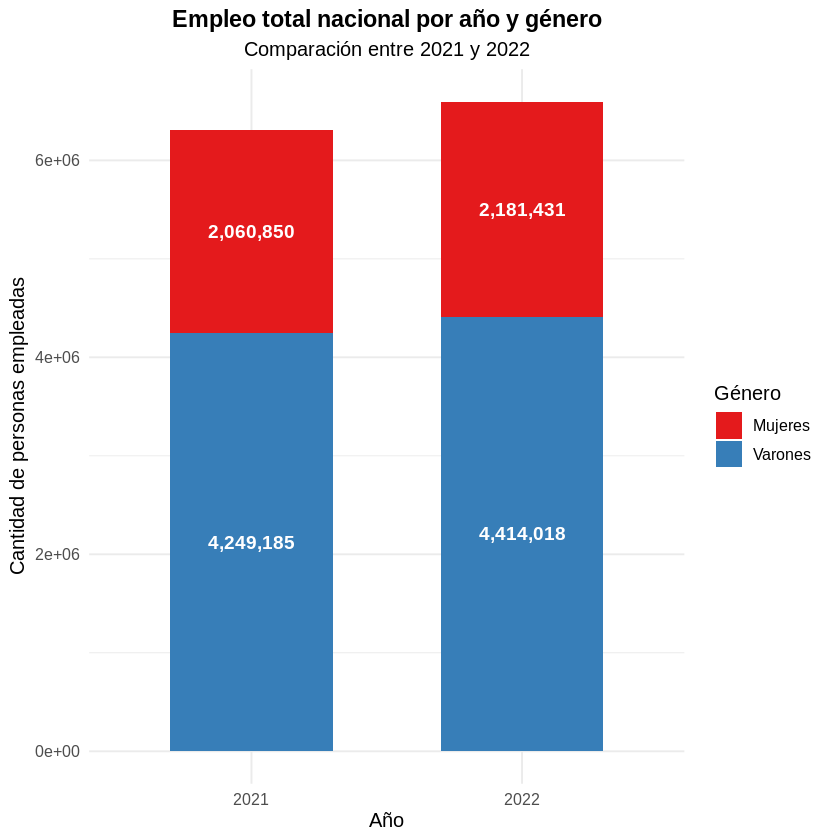

In [ ]:
# 1. Consolidado nacional por año y sexo
empleo_genero_nacional <- datos_genero %>%
  group_by(anio, genero) %>%
  summarise(empleo_total = sum(empleo, na.rm = TRUE), .groups = "drop") %>%
  mutate(genero = case_when(
    genero == "M" ~ "Varones",
    genero == "F" ~ "Mujeres",
    TRUE ~ genero
  ))

# 2. Gráfico de barras apiladas
ggplot(empleo_genero_nacional, aes(x = as.factor(anio), y = empleo_total, fill = genero)) +
  geom_bar(stat = "identity", width = 0.6) +
  scale_fill_manual(values = c("Mujeres" = "#e41a1c", "Varones" = "#377eb8")) +
  geom_text(aes(label = scales::comma(empleo_total)),
            position = position_stack(vjust = 0.5),
            color = "white", size = 4, fontface = "bold") +
  labs(
    title = "Empleo total nacional por año y género",
    subtitle = "Comparación entre 2021 y 2022",
    x = "Año",
    y = "Cantidad de personas empleadas",
    fill = "Género"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5)
  )

#7) indice concentracion industrial por **provincia** (2022)


El índice HHI  (Herfindahl-Hirschman Index) mide cuán concentrado está el empleo en pocos sectores dentro de cada provincia.

* Si **HHI ≈ 1**, el empleo está muy concentrado en pocos sectores.
* Si **HHI ≈ 0,** hay una distribución más equitativa entre muchos sectores.

Lo consideramos importante para detectar provincias con poca diversificación productiva.

### Fórmula

El HHI se calcula como la suma de los cuadrados de las participaciones de empleo de cada sector:

$$
HHI = \sum_{i=1}^{N} s_i^2
$$

In [ ]:
establecimientos <- establecimientos %>%
  mutate(
    empleo = as.numeric(empleo),
    proporcion_mujeres = as.numeric(proporcion_mujeres)
  )

# 1. Proporción promedio de mujeres por provincia
prop_mujeres_prov <- establecimientos %>%
  group_by(provincia_id) %>%
  summarise(prop_mujeres = mean(proporcion_mujeres, na.rm = TRUE))

# 2. Empleo total por provincia
empleo_prov <- datos_total %>%
  group_by(provincia_id) %>%
  summarise(empleo_total = sum(empleo, na.rm = TRUE))

# 3. Número de sectores distintos (clae2) por provincia
n_sectores_prov <- datos_total %>%
  group_by(provincia_id) %>%
  summarise(n_sectores = n_distinct(clae2))

# 4. Índice de concentración sectorial (HHI)
hhi_provincia <- datos_total %>%
  group_by(provincia_id, clae2) %>%
  summarise(empleo = sum(empleo, na.rm = TRUE), .groups = "drop") %>%
  group_by(provincia_id) %>%
  mutate(p = empleo / sum(empleo)) %>%  # esta es la formula de participación relativa del sector en la provincia
  summarise(HHI = sum(p^2), .groups = "drop")  # suma de cuadrados de participaciones

# 5. Unimos todo
provincia_data <- empleo_prov %>%
  left_join(n_sectores_prov, by = "provincia_id") %>%
  left_join(prop_mujeres_prov, by = "provincia_id") %>%
  left_join(hhi_provincia, by = "provincia_id") %>%
  left_join(
    ubicacion %>% select(provincia_id, provincia) %>% distinct(),
    by = "provincia_id"
  ) %>%
  mutate(brecha_genero = prop_mujeres - 0.5) %>%
  select(provincia, HHI, prop_mujeres, empleo_total, n_sectores, brecha_genero)

# Mostramos tabla final
print(provincia_data)

# A tibble: 24 × 6
   provincia       HHI prop_mujeres empleo_total n_sectores brecha_genero
   <chr>         <dbl>        <dbl>        <dbl>      <int>         <dbl>
 1 CABA         0.0336        0.372      3137197         87        -0.128
 2 Buenos Aires 0.0409        0.369      4115444         87        -0.131
 3 Catamarca    0.0569        0.326        63784         77        -0.174
 4 Cordoba      0.0455        0.347      1050882         85        -0.153
 5 Corrientes   0.0647        0.264       159982         84        -0.236
 6 Chaco        0.0624        0.266       170500         83        -0.234
 7 Chubut       0.0531        0.400       196317         82        -0.100
 8 Entre Rios   0.0698        0.319       278325         80        -0.181
 9 Formosa      0.0816        0.293        51482         75        -0.207
10 Jujuy        0.0671        0.328       122316         81        -0.172
# ℹ 14 more rows


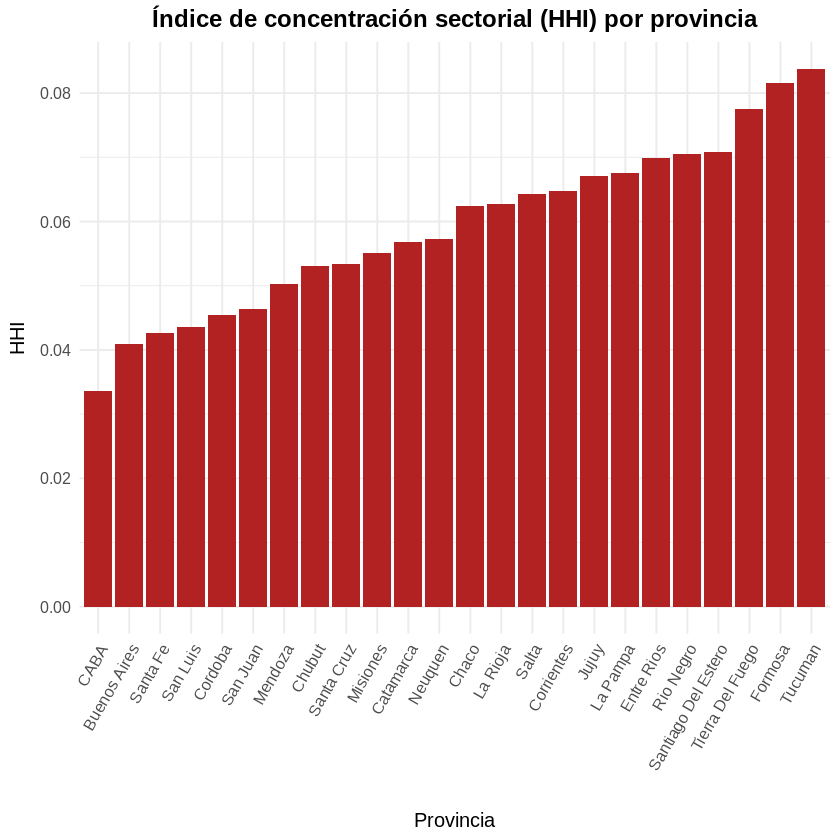

In [ ]:

# Aseguramos el orden de las provincias según HHI descendente
provincia_data <- provincia_data %>%
  mutate(provincia = fct_reorder(provincia, HHI))

# Gráfico de barras
ggplot(provincia_data, aes(x = provincia, y = HHI)) +
  geom_bar(stat = "identity", fill = "#b22222") +
  labs(
    title = "Índice de concentración sectorial (HHI) por provincia",
    x = "Provincia",
    y = "HHI"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 60, hjust = 1),
    plot.title = element_text(face = "bold", hjust = 0.5))

#8 ) Proporcion de mujeres por region 2022

La region menos equititativa es el NEA con solamente 27,8% de la cantidad de mujeres empleadas
La region mas equitativa, Patagonia, aunque sigue existiendo brecha de genero (39,6%)

In [ ]:

# Proporción promedio por provincia
prop_mujeres_prov <- establecimientos %>%
  group_by(provincia_id) %>%
  summarise(prop_mujeres = mean(proporcion_mujeres, na.rm = TRUE)) %>%
  left_join(ubicacion %>% select(provincia_id, provincia) %>% distinct(), by = "provincia_id")

# Le asignamos región (ya la definimos en el cod anterior)
prop_mujeres_region <- prop_mujeres_prov %>%
  left_join(regiones, by = "provincia") %>%
  filter(!is.na(region)) %>%
  group_by(region) %>%
  summarise(
    proporcion_mujeres = mean(prop_mujeres, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(desc(proporcion_mujeres))

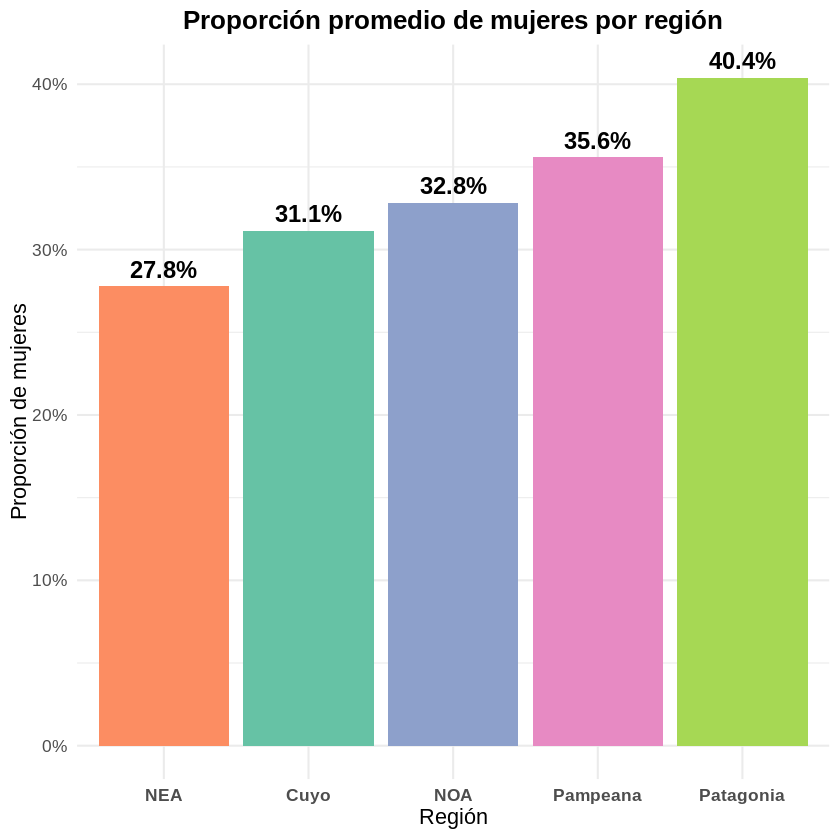

In [ ]:

ggplot(prop_mujeres_region, aes(x = reorder(region, proporcion_mujeres),
                                y = proporcion_mujeres, fill = region)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = scales::percent(proporcion_mujeres, accuracy = 0.1)),
            vjust = -0.5, color = "black", size = 5, fontface = "bold") +
  labs(
    title = "Proporción promedio de mujeres por región",
    x = "Región",
    y = "Proporción de mujeres",
    fill = "Región"
  ) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  scale_fill_brewer(palette = "Set2") +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5),
    axis.text.x = element_text(face = "bold"),  # 👈 acá se cambia
    legend.position = "none"
  )

#9)  Claustering de provincias por grado de diversificación productiva y grado de internacionalización de su economía.

  En este punto realizamos una comparativa de provincias por diversificacion productiva e internacionalizacion, este ultimo en base a la proporción de empresas exportadoras sobre la cantidad de establecimientos productivos totales

Luego,establecimos 4 cuadrantes que nos explica el nivel de internacionalizacion y diversificacion lo cual es util para saber si provincias son mas debiles ante shocks desconocidos (por ej, que una provincia dependa de pocos sectores y que encima no exporte, es sensible a crisis economicas internas)



In [ ]:
# 1. Asegurar formato correcto
establecimientos <- establecimientos %>%
  mutate(
    empleo = as.numeric(empleo),
    proporcion_mujeres = as.numeric(proporcion_mujeres)
  )

# 2. Proporción promedio de mujeres por provincia
prop_mujeres_prov <- establecimientos %>%
  group_by(provincia_id) %>%
  summarise(prop_mujeres = mean(proporcion_mujeres, na.rm = TRUE), .groups = "drop")

# 3. Empleo total por provincia
empleo_prov <- datos_total %>%
  group_by(provincia_id) %>%
  summarise(empleo_total = sum(empleo, na.rm = TRUE), .groups = "drop")

# 4. Número de sectores distintos (clae2) por provincia
n_sectores_prov <- datos_total %>%
  group_by(provincia_id) %>%
  summarise(n_sectores = n_distinct(clae2), .groups = "drop")

# 5. HHI por provincia
hhi_provincia <- datos_total %>%
  group_by(provincia_id, clae2) %>%
  summarise(empleo = sum(empleo, na.rm = TRUE), .groups = "drop") %>%
  group_by(provincia_id) %>%
  mutate(p = empleo / sum(empleo)) %>%
  summarise(HHI = sum(p^2), .groups = "drop")

# 6. Proporción de empresas exportadoras
exportadoras_prov <- datos_total %>%
  group_by(provincia_id) %>%
  summarise(
    empresas_totales = sum(establecimientos, na.rm = TRUE),
    empresas_exportadoras = sum(empresas_exportadoras, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(prop_exportadoras = empresas_exportadoras / empresas_totales)

# 7. Diccionario de regiones
regiones <- tibble(
  provincia = c("Salta", "Jujuy", "Tucumán", "Santiago del Estero", "Catamarca", "La Rioja",
                "Chaco", "Corrientes", "Formosa", "Misiones",
                "Mendoza", "San Juan", "San Luis",
                "Buenos Aires", "CABA", "Córdoba", "Santa Fe", "Entre Ríos", "La Pampa",
                "Neuquén", "Río Negro", "Chubut", "Santa Cruz", "Tierra del Fuego"),
  region = c(rep("NOA", 6),
             rep("NEA", 4),
             rep("Cuyo", 3),
             rep("Pampeana", 6),
             rep("Patagonia", 5))
)

# 8. Consolidado final por provincia
provincia_data <- empleo_prov %>%
  left_join(n_sectores_prov, by = "provincia_id") %>%
  left_join(prop_mujeres_prov, by = "provincia_id") %>%
  left_join(hhi_provincia, by = "provincia_id") %>%
  left_join(exportadoras_prov %>% select(provincia_id, prop_exportadoras), by = "provincia_id") %>%
  left_join(ubicacion %>% select(provincia_id, provincia) %>% distinct(), by = "provincia_id") %>%
  left_join(regiones, by = "provincia") %>%
  mutate(brecha_genero = prop_mujeres - 0.5)


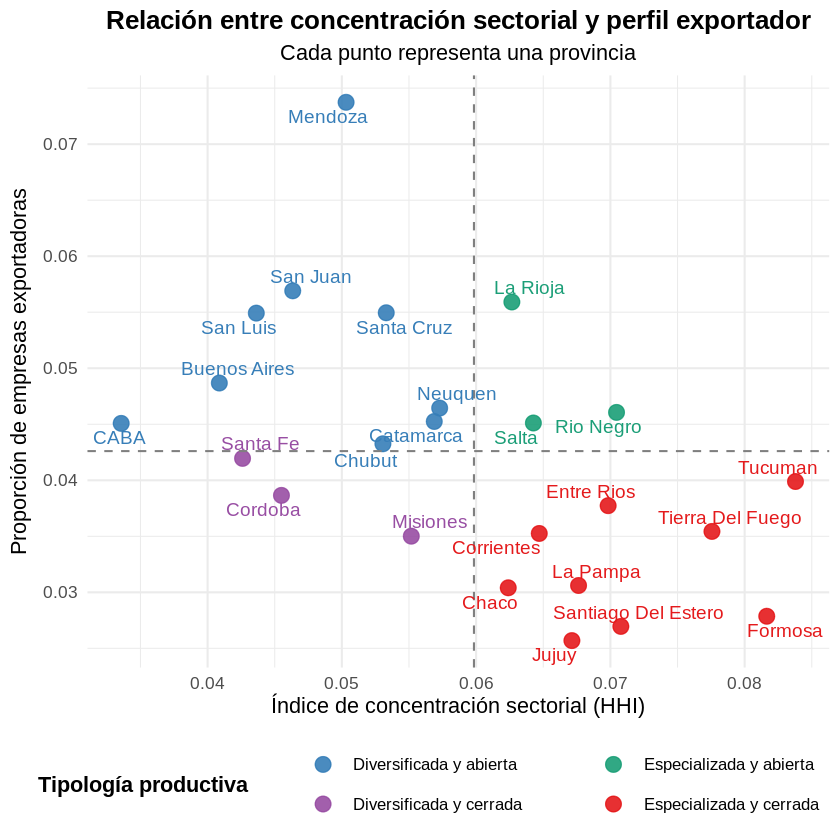

In [ ]:

# Cálculo de medianas
mediana_hhi <- median(provincia_data$HHI, na.rm = TRUE)
mediana_export <- median(provincia_data$prop_exportadoras, na.rm = TRUE)

# Clasificación de provincias por cuadrante
provincia_data <- provincia_data %>%
  mutate(cuadrante = case_when(
    HHI >= mediana_hhi & prop_exportadoras >= mediana_export ~ " Especializada y abierta",
    HHI <  mediana_hhi & prop_exportadoras >= mediana_export ~ " Diversificada y abierta",
    HHI <  mediana_hhi & prop_exportadoras <  mediana_export ~ " Diversificada y cerrada",
    HHI >= mediana_hhi & prop_exportadoras <  mediana_export ~ " Especializada y cerrada"
  ))

#grafico
ggplot(provincia_data, aes(x = HHI, y = prop_exportadoras, color = cuadrante)) +
  geom_point(size = 4, alpha = 0.9) +
  geom_vline(xintercept = mediana_hhi, linetype = "dashed", color = "gray50") +
  geom_hline(yintercept = mediana_export, linetype = "dashed", color = "gray50") +
  geom_text_repel(aes(label = provincia), size = 4, max.overlaps = 30, show.legend = FALSE) +
  labs(
    title = "Relación entre concentración sectorial y perfil exportador",
    subtitle = "Cada punto representa una provincia",
    x = "Índice de concentración sectorial (HHI)",
    y = "Proporción de empresas exportadoras",
    color = "Tipología productiva"
  ) +
  scale_color_manual(values = c(
    " Especializada y abierta"      = "#1b9e77",
    " Diversificada y abierta" = "#377eb8",
    " Diversificada y cerrada"     = "#984ea3",
    " Especializada y cerrada"     = "#e41a1c"
  )) +
  guides(color = guide_legend(nrow = 2)) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 0.5),
    plot.subtitle = element_text(hjust = 0.5),
    legend.position = "bottom",
    legend.text = element_text(size = 10),
    legend.title = element_text(face = "bold")
  )

#10) Top 10 departamentos con más empleo en el año 2022

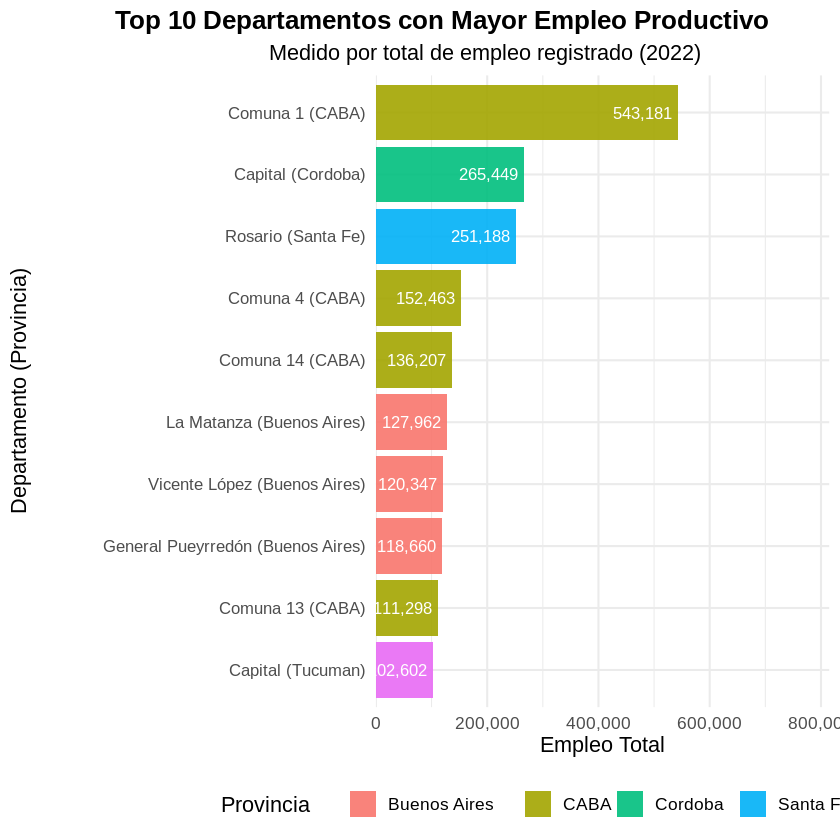

In [ ]:

top_departamentos <- datos_total %>%
  filter(anio == 2022) %>%
  group_by(nombre_departamento = paste0(departamento, " (", provincia, ")")) %>%
  summarise(empleo_total = sum(empleo, na.rm = TRUE), .groups = "drop") %>%
  arrange(desc(empleo_total)) %>%
  slice_head(n = 10) %>%

  # Extraemos las provincias para usar como color
  separate(nombre_departamento, into = c("departamento", "provincia"), sep = " \\(", remove = FALSE) %>%
  mutate(provincia = str_remove(provincia, "\\)"))

# Gráficamos
ggplot(top_departamentos, aes(y = reorder(nombre_departamento, empleo_total),
                               x = empleo_total, fill = provincia)) +
  geom_col(alpha = 0.9) +
  geom_text(aes(label = comma(empleo_total)),
            hjust = 1.1, size = 3.5, color = "white") +
  scale_x_continuous(labels = comma, expand = expansion(mult = c(0, 0.5))) +
  labs(
    title = "Top 10 Departamentos con Mayor Empleo Productivo",
    subtitle = "Medido por total de empleo registrado (2022)",
    x = "Empleo Total",
    y = "Departamento (Provincia)",
    fill = "Provincia"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    plot.title = element_text(face = "bold", hjust = 1.3),
    plot.subtitle = element_text(hjust = -5),
    axis.text.y = element_text(size = 10),
    legend.position = "bottom"
  )

#11 ) Variación del empleo por Gran Sector productivo (2022)

In [ ]:

# Paso 1: Asegurar tipo correcto y evitar duplicados
datos_total <- datos_total %>%
  mutate(clae2 = as.character(clae2))

actividades_filtrada <- actividades %>%
  mutate(clae2 = as.character(clae2)) %>%
  distinct(clae2, letra_desc)

# Paso 2: Unir datos con descripciones sectoriales
datos_total_letra <- datos_total %>%
  left_join(actividades_filtrada, by = "clae2")

# Paso 3: Crear nueva variable sector_agregado
datos_total_letra <- datos_total_letra %>%
  mutate(sector_agregado = case_when(
    letra_desc %in% c("AGRICULTURA, GANADERÍA, CAZA, SILVICULTURA Y PESCA",
                      "EXPLOTACION DE MINAS Y CANTERAS") ~ "Agro y recursos naturales",
    letra_desc %in% c("INDUSTRIA MANUFACTURERA", "CONSTRUCCIÓN") ~ "Industria y construcción",
    letra_desc %in% c("SUMINISTRO DE ELECTRICIDAD, GAS, VAPOR Y AIRE ACONDICIONADO",
                      "SUMINISTRO DE AGUA; CLOACAS; GESTIÓN DE RESIDUOS Y RECUPERACIÓN DE MATERIALES Y SANEAMIENTO PUBLICO") ~ "Servicios públicos y ambientales",
    letra_desc %in% c("COMERCIO AL POR MAYOR Y AL POR MENOR; REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS",
                      "SERVICIO DE TRANSPORTE Y ALMACENAMIENTO") ~ "Comercio y transporte",
    letra_desc == "SERVICIOS DE ALOJAMIENTO Y SERVICIOS DE COMIDA" ~ "Turismo y gastronomía",
    letra_desc %in% c("INFORMACIÓN Y COMUNICACIONES",
                      "INTERMEDIACIÓN FINANCIERA Y SERVICIOS DE SEGUROS") ~ "Información y finanzas",
    letra_desc %in% c("SERVICIOS INMOBILIARIOS",
                      "SERVICIOS PROFESIONALES, CIENTÍFICOS Y TÉCNICOS",
                      "ACTIVIDADES ADMINISTRATIVAS Y SERVICIOS DE APOYO") ~ "Servicios inmobiliarios y profesionales",
    letra_desc %in% c("ADMINISTRACION PUBLICA, DEFENSA Y SEGURIDAD SOCIAL OBLIGATORIA",
                      "ENSEÑANZA",
                      "SALUD HUMANA Y SERVICIOS SOCIALES") ~ "Sector público y educación",
    letra_desc %in% c("SERVICIOS  ARTÍSTICOS, CULTURALES, DEPORTIVOS  Y DE ESPARCIMIENTO",
                      "SERVICIOS DE ASOCIACIONES Y SERVICIOS PERSONALES",
                      "SERVICIOS DE HOGARES PRIVADOS QUE CONTRATAN SERVICIO DOMESTICO") ~ "Cultura, arte y cuidados",
    letra_desc == "SERVICIOS DE ORGANIZACIONES Y ÓRGANOS EXTRATERRITORIALES" ~ "Otros servicios",
    TRUE ~ "Sin clasificar"
  ))



# Paso 4: Calculamos empleo por año y sector agregado
empleo_agregado <- datos_total_letra %>%
  filter(anio %in% c(2021, 2022)) %>%
  group_by(anio, sector_agregado) %>%
  summarise(empleo = sum(empleo, na.rm = TRUE), .groups = "drop")

# Paso 5: Calculamos variación porcentual interanual
empleo_variacion <- empleo_agregado %>%
  pivot_wider(names_from = anio, values_from = empleo, names_prefix = "empleo_") %>%
  mutate(variacion_pct = (empleo_2022 - empleo_2021) / empleo_2021 * 100)

# Paso 6: Ordenamos y convertimos a factor
empleo_variacion <- empleo_variacion %>%
  arrange(desc(variacion_pct)) %>%
  mutate(sector_agregado = factor(sector_agregado, levels = sector_agregado))



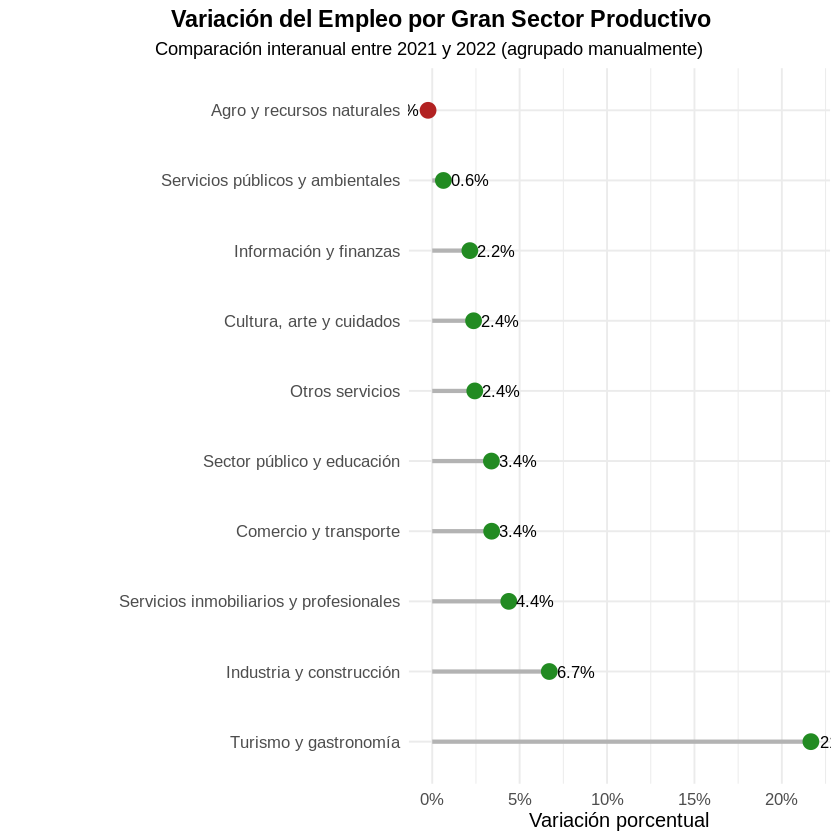

In [ ]:
# Paso 7: Gráfico final  con etiquetas agrupadas y títulos centrados
ggplot(empleo_variacion, aes(x = variacion_pct, y = sector_agregado)) +
  geom_segment(aes(x = 0, xend = variacion_pct, y = sector_agregado, yend = sector_agregado),
               color = "gray70", size = 1.2) +
  geom_point(size = 4,
             color = ifelse(empleo_variacion$variacion_pct > 0, "forestgreen", "firebrick")) +
  geom_text(aes(label = paste0(round(variacion_pct, 1), "%")),
            hjust = ifelse(empleo_variacion$variacion_pct > 0, -0.2, 1.2),
            size = 3.5, color = "black") +
  scale_x_continuous(labels = function(x) paste0(x, "%")) +
  labs(
    title = "Variación del Empleo por Gran Sector Productivo",
    subtitle = "Comparación interanual entre 2021 y 2022 (agrupado manualmente)",
    x = "Variación porcentual",
    y = NULL
  ) +
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(face = "bold", size = 14, hjust = 2),
    plot.subtitle = element_text(size = 11, hjust =2),
    axis.text.y = element_text(size = 10),
    axis.text.x = element_text(size = 10)
  )